In [124]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
try:
    df = pd.read_excel("OnlineRetail.xlsx")
    print("Dataset cargado exitosamente.")
    print("Dimensiones iniciales:", df.shape)
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo 'OnlineRetail.xlsx' esté en el mismo directorio que tu notebook.")

print("\nPrimeras filas del dataset:")
print(df.head())

Error: Asegúrate de que el archivo 'OnlineRetail.xlsx' esté en el mismo directorio que tu notebook.

Primeras filas del dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
1    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
2    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
3    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
4    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
1 2010-12-01 08:26:00       4.25       17850  United Kingdom       25.50   
2 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4 2010-12-01 08:26:00       7.65       17850  United Kingd

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 532617
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      397924 non-null  object        
 1   StockCode      397924 non-null  object        
 2   Description    397924 non-null  object        
 3   Quantity       397924 non-null  int64         
 4   InvoiceDate    397924 non-null  datetime64[ns]
 5   UnitPrice      397924 non-null  float64       
 6   CustomerID     397924 non-null  int64         
 7   Country        397924 non-null  object        
 8   TotalPrice     397924 non-null  float64       
 9   Year           397924 non-null  int32         
 10  Month          397924 non-null  int32         
 11  Semester       397924 non-null  int64         
 12  Year_Semester  397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(2), int64(3), object(5)
memory usage: 39.5+ MB


In [127]:
df.isnull().sum()

InvoiceNo        0
StockCode        0
Description      0
Quantity         0
InvoiceDate      0
UnitPrice        0
CustomerID       0
Country          0
TotalPrice       0
Year             0
Month            0
Semester         0
Year_Semester    0
dtype: int64

# Limpieza del dataset

In [128]:
# Eliminamos filas con nulos en 'CustomerID' y 'Description'
df.dropna(axis= 0, subset=['CustomerID', 'Description'], inplace=True)
print(f"Dimensiones tras eliminar nulos en CustomerID y Description: {df.shape}")

Dimensiones tras eliminar nulos en CustomerID y Description: (397924, 13)


In [129]:
# Convertimos 'CustomerID' a entero
df['CustomerID'] = df['CustomerID'].astype(int)

In [130]:
# Eliminamos transacciones con cantidad negativa o cero
df = df[df['Quantity'] > 0]
print(f"Dimensiones finales del dataset limpio: {df.shape}")

Dimensiones finales del dataset limpio: (397924, 13)


# Descripcion del dataset

In [131]:
# Número de transacciones (facturas únicas)
num_transacciones = df['InvoiceNo'].nunique()
print(f"Número de transacciones únicas: {num_transacciones}")

Número de transacciones únicas: 18536


In [132]:
# Número de ítems únicos
num_items = df['Description'].nunique()
print(f"Número de ítems únicos: {num_items}")

Número de ítems únicos: 3877


In [133]:
# Número de clientes únicos
num_clientes = df['CustomerID'].nunique()
print(f"Número de clientes únicos: {num_clientes}")

Número de clientes únicos: 4339


# División del Dataset


DIVISIÓN DEL DATASET EN PARTICIONES

PARTICIÓN 1: DIVISIÓN TEMPORAL (SEMESTRES)



JUSTIFICACIÓN:
La división por semestres permite identificar patrones de estacionalidad.
- Primer semestre (Enero-Junio): Post-navidad, primavera
- Segundo semestre (Julio-Diciembre): Verano, otoño, temporada navideña

EXPECTATIVAS PREVIAS:
1. Mayor volumen de ventas en segundo semestre (temporada navideña)
2. Productos diferentes tendrán demanda en cada semestre
3. Ticket promedio mayor en S2 (compras de regalos)

RESULTADOS:
Semestre 1: 146,488 transacciones | Ventas: £3,421,091.76 | Ticket: £462.12
Semestre 2: 251,436 transacciones | Ventas: £5,490,316.14 | Ticket: £493.16

PARTICIÓN 2: DIVISIÓN GEOGRÁFICA (UK vs INTERNACIONAL)

JUSTIFICACIÓN:
División geográfica para distinguir mercado doméstico vs internacional.
- UK: mercado principal local
- Internacional: expansión y diversificación de mercados

EXPECTATIVAS PREVIAS:
1. UK tendrá mayor volumen de transacciones (mercado principal)
2. Internacional puede tener tickets promedio más altos (compras al por mayor)
3. Productos popula

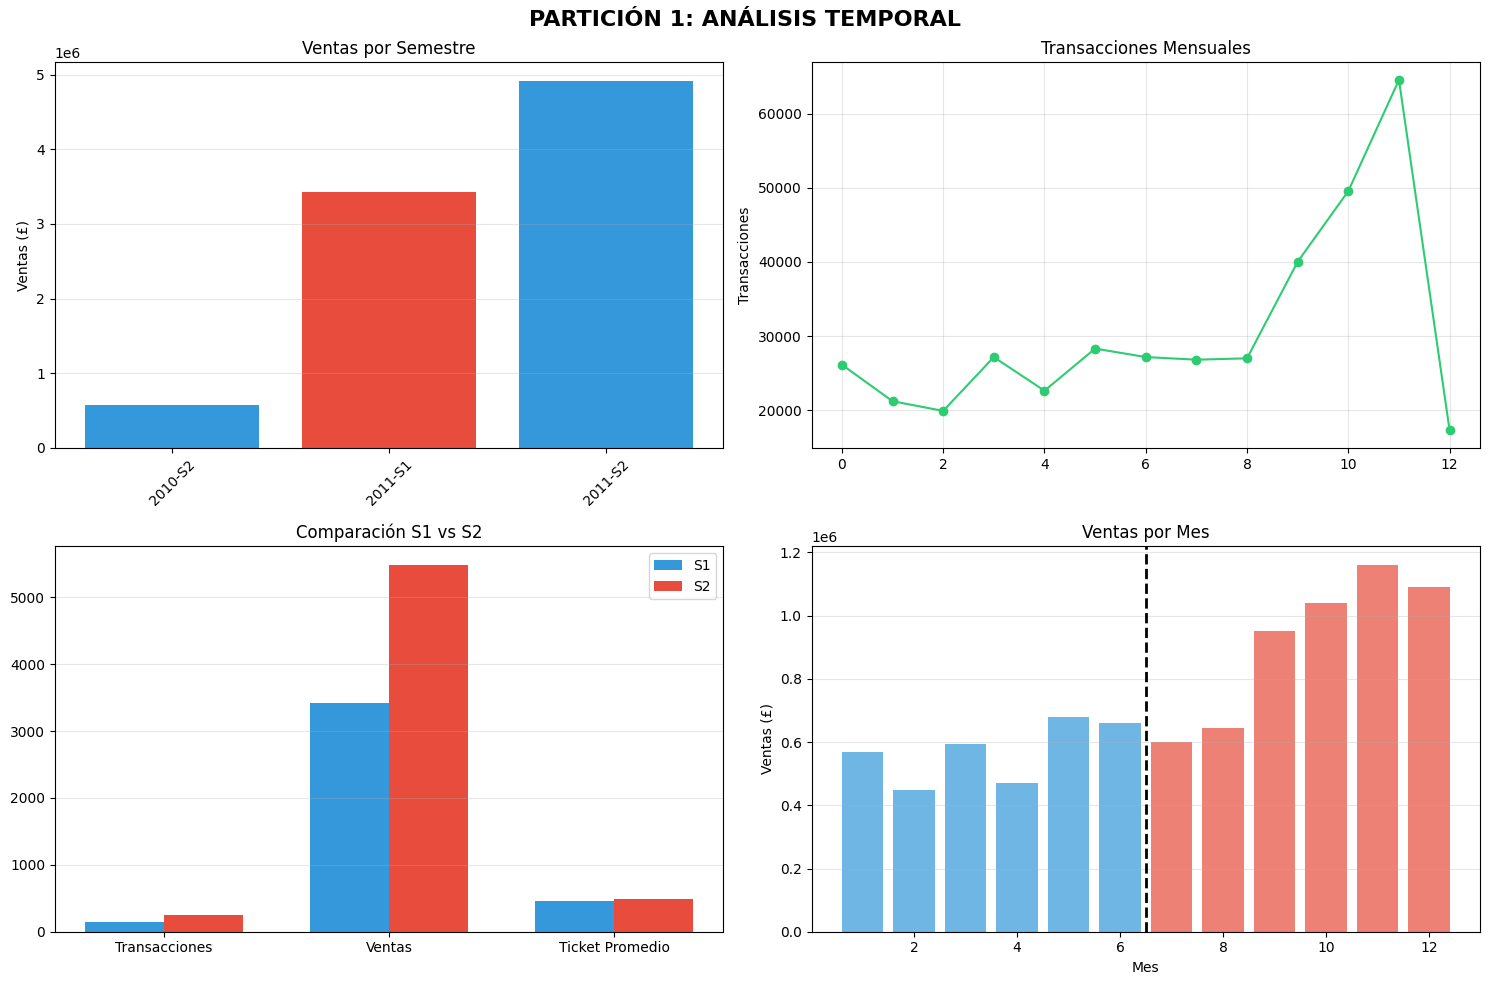

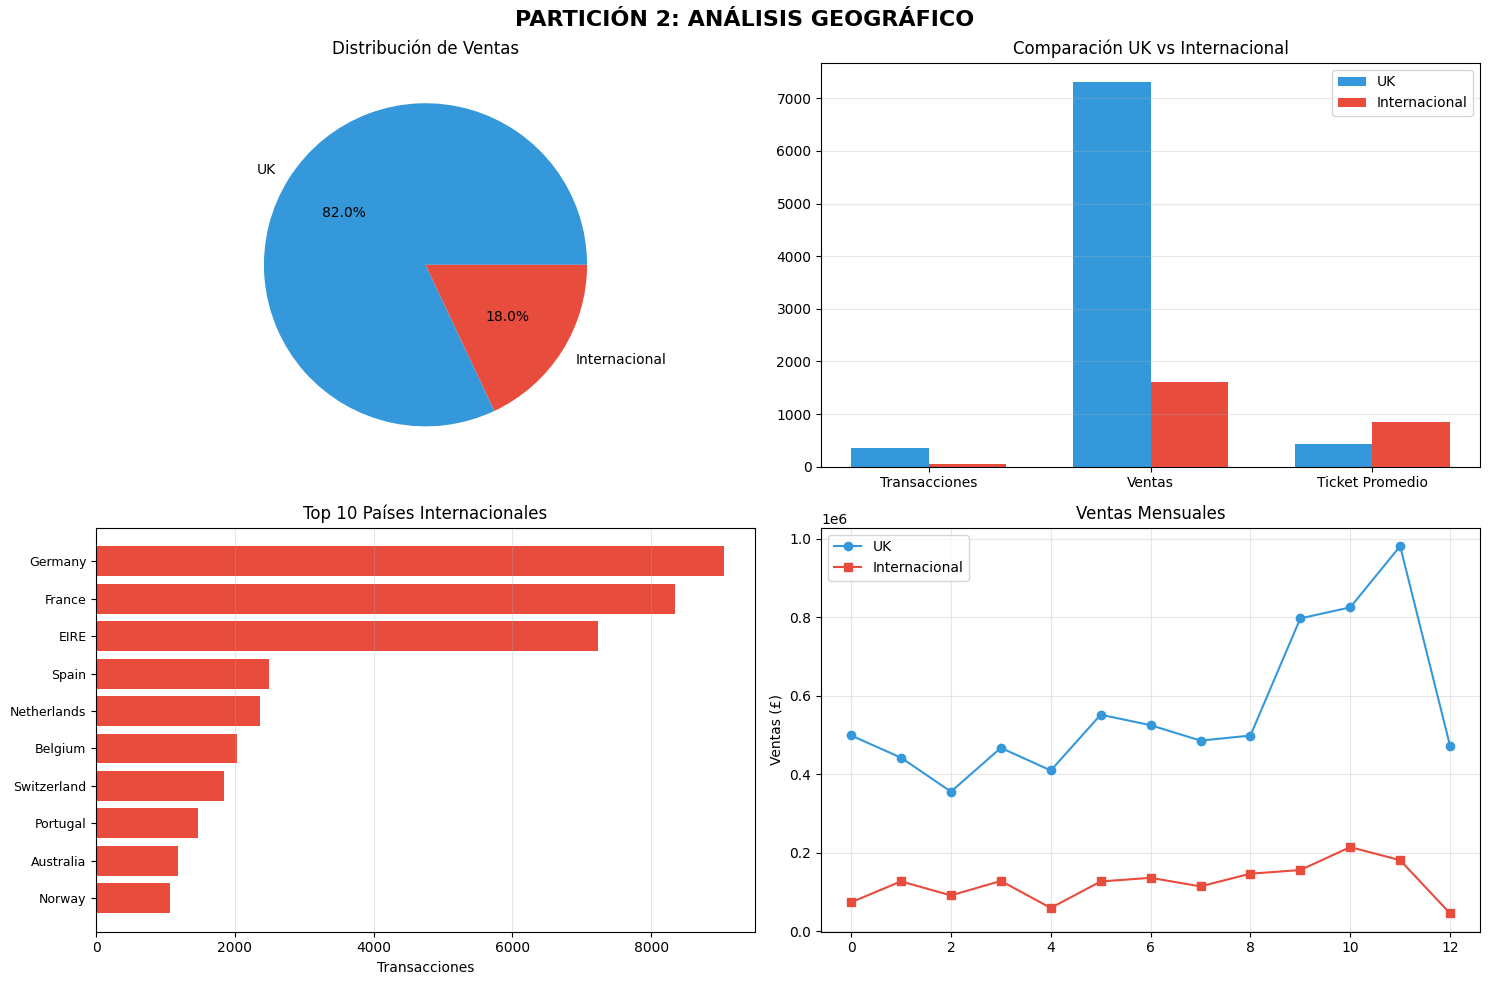


✅ Análisis completado. Gráficas guardadas.


In [134]:
# ============================================
# PREPARACIÓN DE DATOS
# ============================================

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("\n" + "="*70)
print("DIVISIÓN DEL DATASET EN PARTICIONES")
print("="*70)

# ============================================
# PARTICIÓN 1: TEMPORAL (por semestre)
# ============================================

print("\n" + "="*70)
print("PARTICIÓN 1: DIVISIÓN TEMPORAL (SEMESTRES)")
print("="*70)

# Crear columnas temporales
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Semester'] = df['InvoiceDate'].dt.to_period('Q').apply(lambda x: 1 if x.quarter <= 2 else 2)
df['Year_Semester'] = df['Year'].astype(str) + '-S' + df['Semester'].astype(str)

# Dividir en semestres
df_semester_1 = df[df['Semester'] == 1].copy()
df_semester_2 = df[df['Semester'] == 2].copy()

print("\nJUSTIFICACIÓN:")
print("La división por semestres permite identificar patrones de estacionalidad.")
print("- Primer semestre (Enero-Junio): Post-navidad, primavera")
print("- Segundo semestre (Julio-Diciembre): Verano, otoño, temporada navideña")

print("\nEXPECTATIVAS PREVIAS:")
print("1. Mayor volumen de ventas en segundo semestre (temporada navideña)")
print("2. Productos diferentes tendrán demanda en cada semestre")
print("3. Ticket promedio mayor en S2 (compras de regalos)")

# Análisis comparativo
s1_sales = df_semester_1['TotalPrice'].sum()
s2_sales = df_semester_2['TotalPrice'].sum()
s1_avg = df_semester_1.groupby('InvoiceNo')['TotalPrice'].sum().mean()
s2_avg = df_semester_2.groupby('InvoiceNo')['TotalPrice'].sum().mean()

print("\nRESULTADOS:")
print(f"Semestre 1: {len(df_semester_1):,} transacciones | Ventas: £{s1_sales:,.2f} | Ticket: £{s1_avg:.2f}")
print(f"Semestre 2: {len(df_semester_2):,} transacciones | Ventas: £{s2_sales:,.2f} | Ticket: £{s2_avg:.2f}")

# ============================================
# PARTICIÓN 2: GEOGRÁFICA (UK vs Internacional)
# ============================================

print("\n" + "="*70)
print("PARTICIÓN 2: DIVISIÓN GEOGRÁFICA (UK vs INTERNACIONAL)")
print("="*70)

# Dividir en UK vs resto del mundo
df_uk = df[df['Country'] == 'United Kingdom'].copy()
df_international = df[df['Country'] != 'United Kingdom'].copy()

print("\nJUSTIFICACIÓN:")
print("División geográfica para distinguir mercado doméstico vs internacional.")
print("- UK: mercado principal local")
print("- Internacional: expansión y diversificación de mercados")

print("\nEXPECTATIVAS PREVIAS:")
print("1. UK tendrá mayor volumen de transacciones (mercado principal)")
print("2. Internacional puede tener tickets promedio más altos (compras al por mayor)")
print("3. Productos populares diferirán entre mercados")

# Análisis comparativo
uk_sales = df_uk['TotalPrice'].sum()
int_sales = df_international['TotalPrice'].sum()
uk_avg = df_uk.groupby('InvoiceNo')['TotalPrice'].sum().mean()
int_avg = df_international.groupby('InvoiceNo')['TotalPrice'].sum().mean()

print("\nRESULTADOS:")
print(f"UK: {len(df_uk):,} transacciones | Ventas: £{uk_sales:,.2f} | Ticket: £{uk_avg:.2f}")
print(f"Internacional: {len(df_international):,} transacciones | Ventas: £{int_sales:,.2f} | Ticket: £{int_avg:.2f}")
print(f"Países internacionales: {df_international['Country'].nunique()}")

# ============================================
# VISUALIZACIONES
# ============================================

# GRÁFICA 1: PARTICIÓN TEMPORAL
fig1, axes1 = plt.subplots(2, 2, figsize=(15, 10))
fig1.suptitle('PARTICIÓN 1: ANÁLISIS TEMPORAL', fontsize=16, fontweight='bold')

# Ventas por semestre
semester_sales = df.groupby('Year_Semester')['TotalPrice'].sum().sort_index()
axes1[0, 0].bar(semester_sales.index, semester_sales.values, color=['#3498db', '#e74c3c'])
axes1[0, 0].set_title('Ventas por Semestre')
axes1[0, 0].set_ylabel('Ventas (£)')
axes1[0, 0].tick_params(axis='x', rotation=45)
axes1[0, 0].grid(axis='y', alpha=0.3)

# Transacciones mensuales
monthly_trans = df.groupby(df['InvoiceDate'].dt.to_period('M')).size()
axes1[0, 1].plot(range(len(monthly_trans)), monthly_trans.values, marker='o', color='#2ecc71')
axes1[0, 1].set_title('Transacciones Mensuales')
axes1[0, 1].set_ylabel('Transacciones')
axes1[0, 1].grid(alpha=0.3)

# Comparación S1 vs S2
metrics = ['Transacciones', 'Ventas', 'Ticket Promedio']
s1_vals = [len(df_semester_1)/1000, s1_sales/1000, s1_avg]
s2_vals = [len(df_semester_2)/1000, s2_sales/1000, s2_avg]
x = np.arange(len(metrics))
width = 0.35
axes1[1, 0].bar(x - width/2, s1_vals, width, label='S1', color='#3498db')
axes1[1, 0].bar(x + width/2, s2_vals, width, label='S2', color='#e74c3c')
axes1[1, 0].set_title('Comparación S1 vs S2')
axes1[1, 0].set_xticks(x)
axes1[1, 0].set_xticklabels(metrics)
axes1[1, 0].legend()
axes1[1, 0].grid(axis='y', alpha=0.3)

# Ventas por mes
monthly_sales = df.groupby(df['InvoiceDate'].dt.month)['TotalPrice'].sum()
colors_month = ['#3498db']*6 + ['#e74c3c']*6
axes1[1, 1].bar(range(1, 13), monthly_sales.values, color=colors_month, alpha=0.7)
axes1[1, 1].set_title('Ventas por Mes')
axes1[1, 1].set_xlabel('Mes')
axes1[1, 1].set_ylabel('Ventas (£)')
axes1[1, 1].axvline(x=6.5, color='black', linestyle='--', linewidth=2)
axes1[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('particion_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

# GRÁFICA 2: PARTICIÓN GEOGRÁFICA
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 10))
fig2.suptitle('PARTICIÓN 2: ANÁLISIS GEOGRÁFICO', fontsize=16, fontweight='bold')

# Pie chart ventas
geo_data = [uk_sales, int_sales]
geo_labels = ['UK', 'Internacional']
axes2[0, 0].pie(geo_data, labels=geo_labels, autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
axes2[0, 0].set_title('Distribución de Ventas')

# Comparación métricas
metrics_geo = ['Transacciones', 'Ventas', 'Ticket Promedio']
uk_vals = [len(df_uk)/1000, uk_sales/1000, uk_avg]
int_vals = [len(df_international)/1000, int_sales/1000, int_avg]
x = np.arange(len(metrics_geo))
axes2[0, 1].bar(x - width/2, uk_vals, width, label='UK', color='#3498db')
axes2[0, 1].bar(x + width/2, int_vals, width, label='Internacional', color='#e74c3c')
axes2[0, 1].set_title('Comparación UK vs Internacional')
axes2[0, 1].set_xticks(x)
axes2[0, 1].set_xticklabels(metrics_geo)
axes2[0, 1].legend()
axes2[0, 1].grid(axis='y', alpha=0.3)

# Top países
top_countries = df_international['Country'].value_counts().head(10)
axes2[1, 0].barh(range(len(top_countries)), top_countries.values, color='#e74c3c')
axes2[1, 0].set_yticks(range(len(top_countries)))
axes2[1, 0].set_yticklabels(top_countries.index, fontsize=9)
axes2[1, 0].set_title('Top 10 Países Internacionales')
axes2[1, 0].set_xlabel('Transacciones')
axes2[1, 0].invert_yaxis()
axes2[1, 0].grid(axis='x', alpha=0.3)

# Evolución mensual UK vs Internacional
monthly_uk = df_uk.groupby(df_uk['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()
monthly_int = df_international.groupby(df_international['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()
axes2[1, 1].plot(range(len(monthly_uk)), monthly_uk.values, marker='o', label='UK', color='#3498db')
axes2[1, 1].plot(range(len(monthly_int)), monthly_int.values, marker='s', label='Internacional', color='#e74c3c')
axes2[1, 1].set_title('Ventas Mensuales')
axes2[1, 1].set_ylabel('Ventas (£)')
axes2[1, 1].legend()
axes2[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('particion_geografica.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Análisis completado. Gráficas guardadas.")

# 3. Minería de Patrones por Partición

In [135]:
# Importar fpmax para itemsets maximales
from mlxtend.frequent_patterns import fpmax

def mineria_patrones(data, nombre, min_sup=0.02):
    # Preparar basket (del labReglasAsociacion.ipynb)
    basket = data.groupby('InvoiceNo')['Description'].apply(list).values
    te = TransactionEncoder()
    te_ary = te.fit(basket).transform(basket)
    df_basket = pd.DataFrame(te_ary, columns=te.columns_)
    
    # 1. Itemsets frecuentes (Apriori - pattern_mining.txt)
    frequent = apriori(df_basket, min_support=min_sup, use_colnames=True)
    
    # 2. Reglas de asociación: support, confidence, lift (pattern_mining.txt)
    rules = association_rules(frequent, metric="confidence", min_threshold=0.3)
    
    # 3. Closed itemsets - simplificación (condensed_representation.txt)
    # Solo itemsets de tamaño > 1 que no tienen supersets con mismo soporte
    closed = frequent[frequent['itemsets'].apply(lambda x: len(x) > 1)]
    
    # 4. Maximal itemsets (condensed_representation.txt)
    maximal = fpmax(df_basket, min_support=min_sup, use_colnames=True)
    
    print(f"{nombre}: {len(frequent)} frecuentes | {len(rules)} reglas | {len(closed)} closed | {len(maximal)} maximales")
    return frequent, rules, closed, maximal

## 3.1 Partición Temporal: Semestre 1

In [136]:
freq_s1, rules_s1, closed_s1, max_s1 = mineria_patrones(df_semester_1, "S1")
print("\nTop 5 reglas por lift:")
print(rules_s1.nlargest(5, 'lift')[['antecedents','consequents','support','confidence','lift']])

S1: 267 frecuentes | 76 reglas | 41 closed | 223 maximales

Top 5 reglas por lift:
                                          antecedents  \
65  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
70                  (GREEN REGENCY TEACUP AND SAUCER)   
67  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
68                   (PINK REGENCY TEACUP AND SAUCER)   
7                    (PINK REGENCY TEACUP AND SAUCER)   

                                          consequents   support  confidence  \
65                  (GREEN REGENCY TEACUP AND SAUCER)  0.027962    0.911894   
70  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...  0.027962    0.593123   
67                   (PINK REGENCY TEACUP AND SAUCER)  0.027962    0.728873   
68  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...  0.027962    0.726316   
7                   (GREEN REGENCY TEACUP AND SAUCER)  0.032014    0.831579   

         lift  
65  19.343133  
70  19.343133  
67  18.932802  
68  18.932802  
7   17.639481  


## 3.2 Partición Temporal: Semestre 2

In [137]:
freq_s2, rules_s2, closed_s2, max_s2 = mineria_patrones(df_semester_2, "S2")
print("\nTop 5 reglas por lift:")
print(rules_s2.nlargest(5, 'lift')[['antecedents','consequents','support','confidence','lift']])

S2: 291 frecuentes | 100 reglas | 54 closed | 237 maximales

Top 5 reglas por lift:
                             antecedents  \
17     (GREEN REGENCY TEACUP AND SAUCER)   
16      (PINK REGENCY TEACUP AND SAUCER)   
18    (ROSES REGENCY TEACUP AND SAUCER )   
19     (GREEN REGENCY TEACUP AND SAUCER)   
98  (WOODEN STAR CHRISTMAS SCANDINAVIAN)   

                             consequents   support  confidence       lift  
17      (PINK REGENCY TEACUP AND SAUCER)  0.020031    0.652047  26.786852  
16     (GREEN REGENCY TEACUP AND SAUCER)  0.020031    0.822878  26.786852  
18     (GREEN REGENCY TEACUP AND SAUCER)  0.023085    0.669271  21.786527  
19    (ROSES REGENCY TEACUP AND SAUCER )  0.023085    0.751462  21.786527  
98  (WOODEN TREE CHRISTMAS SCANDINAVIAN)  0.020300    0.521940  21.053469  


## 3.3 Partición Geográfica: UK

In [138]:
freq_uk, rules_uk, closed_uk, max_uk = mineria_patrones(df_uk, "UK")
print("\nTop 5 reglas por lift:")
print(rules_uk.nlargest(5, 'lift')[['antecedents','consequents','support','confidence','lift']])

UK: 235 frecuentes | 67 reglas | 36 closed | 200 maximales

Top 5 reglas por lift:
                                          antecedents  \
61  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
66                  (GREEN REGENCY TEACUP AND SAUCER)   
63  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
64                   (PINK REGENCY TEACUP AND SAUCER)   
4                    (PINK REGENCY TEACUP AND SAUCER)   

                                          consequents   support  confidence  \
61                  (GREEN REGENCY TEACUP AND SAUCER)  0.020482    0.890339   
66  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...  0.020482    0.557190   
63                   (PINK REGENCY TEACUP AND SAUCER)  0.020482    0.716387   
64  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...  0.020482    0.691684   
4                   (GREEN REGENCY TEACUP AND SAUCER)  0.024266    0.819473   

         lift  
61  24.221015  
66  24.221015  
63  24.192941  
64  24.192941  
4   22.293137  


## 3.4 Partición Geográfica: Internacional

In [139]:
freq_int, rules_int, closed_int, max_int = mineria_patrones(df_international, "Internacional")
print("\nTop 5 reglas por lift:")
print(rules_int.nlargest(5, 'lift')[['antecedents','consequents','support','confidence','lift']])

Internacional: 598 frecuentes | 554 reglas | 319 closed | 384 maximales

Top 5 reglas por lift:
                                           antecedents  \
324  (DOLLY GIRL CHILDRENS CUP, SPACEBOY CHILDRENS ...   
325                        (DOLLY GIRL CHILDRENS BOWL)   
155                   (PACK OF 20 SKULL PAPER NAPKINS)   
156                     (PACK OF 6 SKULL PAPER PLATES)   
157                       (PACK OF 6 SKULL PAPER CUPS)   

                                           consequents   support  confidence  \
324                        (DOLLY GIRL CHILDRENS BOWL)  0.021728    1.000000   
325  (DOLLY GIRL CHILDRENS CUP, SPACEBOY CHILDRENS ...  0.021728    0.773585   
155                     (PACK OF 6 SKULL PAPER PLATES)  0.020138    0.844444   
156                   (PACK OF 20 SKULL PAPER NAPKINS)  0.020138    0.791667   
157                     (PACK OF 6 SKULL PAPER PLATES)  0.022258    0.823529   

          lift  
324  35.603774  
325  35.603774  
155  33.197222  
156  3

## 3.5 Resumen Comparativo

In [140]:
# Resumen comparativo
resumen = pd.DataFrame({
    'Partición': ['S1', 'S2', 'UK', 'Int'],
    'Frecuentes': [len(freq_s1), len(freq_s2), len(freq_uk), len(freq_int)],
    'Reglas': [len(rules_s1), len(rules_s2), len(rules_uk), len(rules_int)],
    'Closed': [len(closed_s1), len(closed_s2), len(closed_uk), len(closed_int)],
    'Maximal': [len(max_s1), len(max_s2), len(max_uk), len(max_int)]
})
print(resumen)

  Partición  Frecuentes  Reglas  Closed  Maximal
0        S1         267      76      41      223
1        S2         291     100      54      237
2        UK         235      67      36      200
3       Int         598     554     319      384


# Evaluación de patrones emergentes

In [141]:
# Funcion para calcular Growth rate, EP y JEP 
def calcular_patrones_emergentes(freq_part1, freq_part2, 
                                  nombre_p1, nombre_p2, 
                                  umbral_gr=0.5, 
                                  umbral_soporte_min=0.01):
    
    # Crear diccionarios para búsqueda rápida
    dict_p1 = dict(zip(freq_part1['itemsets'].apply(frozenset), 
                       freq_part1['support']))
    dict_p2 = dict(zip(freq_part2['itemsets'].apply(frozenset), 
                       freq_part2['support']))
    
    # Itemsets únicos en ambas particiones
    itemsets_totales = set(dict_p1.keys()) | set(dict_p2.keys())
    
    resultados = []
    
    for itemset in itemsets_totales:
        sup_p1 = dict_p1.get(itemset, 0)
        sup_p2 = dict_p2.get(itemset, 0)
        
        # Filtrar por soporte mínimo
        if max(sup_p1, sup_p2) < umbral_soporte_min:
            continue
        
        # Calcular Growth Rate
        if sup_p1 == 0:
            if sup_p2 > 0:
                # Patrón nuevo en P2
                gr = float('inf')
                tipo = 'JEP (Nuevo)'
            else:
                continue
        else:
            gr = (sup_p2 - sup_p1) / sup_p1
            
            # Clasificar patrón
            if gr > umbral_gr:
                tipo = 'EP (Alto crecimiento)'
            elif gr < -umbral_gr:
                tipo = 'EP (Alto decrecimiento)'
            else:
                tipo = 'Normal'
        
        resultados.append({
            'itemset': itemset,
            'items': list(itemset),
            f'support_{nombre_p1}': sup_p1,
            f'support_{nombre_p2}': sup_p2,
            'growth_rate': gr,
            'tipo_patron': tipo,
            'tamaño': len(itemset)
        })
    
    df_resultados = pd.DataFrame(resultados)
    
    # Ordenar por Growth Rate (descendente, JEPs primero)
    df_resultados['es_jep'] = df_resultados['tipo_patron'] == 'JEP (Nuevo)'
    df_resultados = df_resultados.sort_values(['es_jep', 'growth_rate'], 
                                               ascending=[False, False])
    df_resultados = df_resultados.drop('es_jep', axis=1)
    
    return df_resultados

## 4.2 Partición Temporal: Growth Rate (S1 vs S2)

In [142]:
# Calcular patrones emergentes: S1 vs S2
print("\n" + "="*80)
print("ANÁLISIS TEMPORAL: Growth Rate S1 → S2")
print("="*80)

eps_s1_s2 = calcular_patrones_emergentes(
    freq_s1, freq_s2, 
    nombre_p1='S1', nombre_p2='S2',
    umbral_gr=0.5,
    umbral_soporte_min=0.01
)

print(f"\nTotal de patrones analizados: {len(eps_s1_s2)}")
print(f"Emerging Patterns (alto crecimiento): {len(eps_s1_s2[eps_s1_s2['tipo_patron'] == 'EP (Alto crecimiento)'])}")
print(f"Emerging Patterns (alto decrecimiento): {len(eps_s1_s2[eps_s1_s2['tipo_patron'] == 'EP (Alto decrecimiento)'])}")
print(f"Jumping Emerging Patterns (nuevos): {len(eps_s1_s2[eps_s1_s2['tipo_patron'] == 'JEP (Nuevo)'])}")

print("\n" + "-"*80)
print("TOP 10 PATRONES EMERGENTES (Mayor crecimiento S1→S2):")
print("-"*80)

top_crecimiento = eps_s1_s2[eps_s1_s2['tipo_patron'].isin(['EP (Alto crecimiento)', 'JEP (Nuevo)'])].head(10)
for idx, row in top_crecimiento.iterrows():
    items = ', '.join(list(row['items'])[:3])  # Mostrar primeros 3 items
    if len(row['items']) > 3:
        items += f"... (+{len(row['items'])-3} más)"
    
    if row['growth_rate'] == float('inf'):
        gr_str = "NUEVO (inf)"
    else:
        gr_str = f"{row['growth_rate']*100:+.1f}%"
    
    print(f"\n{items}")
    print(f"  S1: {row['support_S1']:.4f} → S2: {row['support_S2']:.4f}")
    print(f"  Growth Rate: {gr_str} | Tipo: {row['tipo_patron']}")

print("\n" + "-"*80)
print("TOP 10 PATRONES EMERGENTES (Mayor decrecimiento S1→S2):")
print("-"*80)

top_decrecimiento = eps_s1_s2[eps_s1_s2['tipo_patron'] == 'EP (Alto decrecimiento)'].head(10)
for idx, row in top_decrecimiento.iterrows():
    items = ', '.join(list(row['items'])[:3])
    if len(row['items']) > 3:
        items += f"... (+{len(row['items'])-3} más)"
    
    print(f"\n{items}")
    print(f"  S1: {row['support_S1']:.4f} → S2: {row['support_S2']:.4f}")
    print(f"  Growth Rate: {row['growth_rate']*100:.1f}% | Tipo: {row['tipo_patron']}")


ANÁLISIS TEMPORAL: Growth Rate S1 → S2

Total de patrones analizados: 407
Emerging Patterns (alto crecimiento): 7
Emerging Patterns (alto decrecimiento): 117
Jumping Emerging Patterns (nuevos): 140

--------------------------------------------------------------------------------
TOP 10 PATRONES EMERGENTES (Mayor crecimiento S1→S2):
--------------------------------------------------------------------------------

JUMBO BAG PAISLEY PARK
  S1: 0.0000 → S2: 0.0271
  Growth Rate: NUEVO (inf) | Tipo: JEP (Nuevo)

HOT WATER BOTTLE KEEP CALM, CHOCOLATE HOT WATER BOTTLE
  S1: 0.0000 → S2: 0.0221
  Growth Rate: NUEVO (inf) | Tipo: JEP (Nuevo)

HOT WATER BOTTLE KEEP CALM, HOT WATER BOTTLE TEA AND SYMPATHY
  S1: 0.0000 → S2: 0.0205
  Growth Rate: NUEVO (inf) | Tipo: JEP (Nuevo)

LUNCH BAG APPLE DESIGN, LUNCH BAG SUKI DESIGN 
  S1: 0.0000 → S2: 0.0208
  Growth Rate: NUEVO (inf) | Tipo: JEP (Nuevo)

JUMBO BAG OWLS
  S1: 0.0000 → S2: 0.0249
  Growth Rate: NUEVO (inf) | Tipo: JEP (Nuevo)

PAPER CHAIN

## 4.3 Partición Geográfica: Growth Rate (UK vs Internacional)

In [143]:

# Calcular patrones emergentes: UK vs Internacional
print("\n" + "="*80)
print("ANÁLISIS GEOGRÁFICO: Growth Rate UK → Internacional")
print("="*80)

eps_uk_int = calcular_patrones_emergentes(
    freq_uk, freq_int, 
    nombre_p1='UK', nombre_p2='Int',
    umbral_gr=0.5,
    umbral_soporte_min=0.01
)

print(f"\nTotal de patrones analizados: {len(eps_uk_int)}")
print(f"Emerging Patterns (alto crecimiento): {len(eps_uk_int[eps_uk_int['tipo_patron'] == 'EP (Alto crecimiento)'])}")
print(f"Emerging Patterns (alto decrecimiento): {len(eps_uk_int[eps_uk_int['tipo_patron'] == 'EP (Alto decrecimiento)'])}")
print(f"Jumping Emerging Patterns (nuevos): {len(eps_uk_int[eps_uk_int['tipo_patron'] == 'JEP (Nuevo)'])}")

print("\n" + "-"*80)
print("TOP 10 PATRONES EMERGENTES (Mayor crecimiento UK→Int):")
print("-"*80)

top_crecimiento_geo = eps_uk_int[eps_uk_int['tipo_patron'].isin(['EP (Alto crecimiento)', 'JEP (Nuevo)'])].head(10)
for idx, row in top_crecimiento_geo.iterrows():
    items = ', '.join(list(row['items'])[:3])
    if len(row['items']) > 3:
        items += f"... (+{len(row['items'])-3} más)"
    
    if row['growth_rate'] == float('inf'):
        gr_str = "NUEVO (inf)"
    else:
        gr_str = f"{row['growth_rate']*100:+.1f}%"
    
    print(f"\n{items}")
    print(f"  UK: {row['support_UK']:.4f} → Int: {row['support_Int']:.4f}")
    print(f"  Growth Rate: {gr_str} | Tipo: {row['tipo_patron']}")

print("\n" + "-"*80)
print("TOP 10 PATRONES EMERGENTES (Mayor decrecimiento UK→Int):")
print("-"*80)

top_decrecimiento_geo = eps_uk_int[eps_uk_int['tipo_patron'] == 'EP (Alto decrecimiento)'].head(10)
for idx, row in top_decrecimiento_geo.iterrows():
    items = ', '.join(list(row['items'])[:3])
    if len(row['items']) > 3:
        items += f"... (+{len(row['items'])-3} más)"
    
    print(f"\n{items}")
    print(f"  UK: {row['support_UK']:.4f} → Int: {row['support_Int']:.4f}")
    print(f"  Growth Rate: {row['growth_rate']*100:.1f}% | Tipo: {row['tipo_patron']}")



ANÁLISIS GEOGRÁFICO: Growth Rate UK → Internacional

Total de patrones analizados: 709
Emerging Patterns (alto crecimiento): 37
Emerging Patterns (alto decrecimiento): 114
Jumping Emerging Patterns (nuevos): 474

--------------------------------------------------------------------------------
TOP 10 PATRONES EMERGENTES (Mayor crecimiento UK→Int):
--------------------------------------------------------------------------------

RED RETROSPOT CAKE STAND, POSTAGE
  UK: 0.0000 → Int: 0.0233
  Growth Rate: NUEVO (inf) | Tipo: JEP (Nuevo)

ROUND SNACK BOXES SET OF4 WOODLAND 
  UK: 0.0000 → Int: 0.1590
  Growth Rate: NUEVO (inf) | Tipo: JEP (Nuevo)

ALARM CLOCK BAKELIKE CHOCOLATE
  UK: 0.0000 → Int: 0.0249
  Growth Rate: NUEVO (inf) | Tipo: JEP (Nuevo)

ALARM CLOCK BAKELIKE RED , POSTAGE
  UK: 0.0000 → Int: 0.0371
  Growth Rate: NUEVO (inf) | Tipo: JEP (Nuevo)

SET OF 36 TEATIME PAPER DOILIES
  UK: 0.0000 → Int: 0.0217
  Growth Rate: NUEVO (inf) | Tipo: JEP (Nuevo)

LUNCH BOX WITH CUTLERY RE

## 4.4 Análisis de Cambios: Interpretación de Patrones Emergentes

In [144]:

    # ============================================
    # INTERPRETACIÓN DE CAMBIOS
    # ============================================

    print("\n" + "="*80)
    print("INTERPRETACIÓN DE PATRONES EMERGENTES Y CAMBIOS ENTRE PARTICIONES")
    print("="*80)

    # ============================================
    # 1. ANÁLISIS TEMPORAL (S1 vs S2)
    # ============================================

    print("\n" + "="*80)
    print("1. CAMBIOS TEMPORALES: ESTACIONALIDAD Y TENDENCIAS (S1 → S2)")
    print("="*80)

    # Productos emergentes en S2 (Jumping Emerging Patterns)
    jeps_s2 = eps_s1_s2[eps_s1_s2['tipo_patron'] == 'JEP (Nuevo)']
    if len(jeps_s2) > 0:
        print(f"\n PRODUCTOS EMERGENTES EN S2 (nuevos en el semestre posterior):")
        print(f"   Total: {len(jeps_s2)} productos")
        
        # Mostrar algunos ejemplos
        ejemplos = jeps_s2[jeps_s2['tamaño'] == 1].head(5)
        for idx, row in ejemplos.iterrows():
            producto = list(row['items'])[0] if len(row['items']) == 1 else f"{len(row['items'])} items"
            print(f"   - {producto} (soporte S2: {row['support_S2']:.4f})")

    # Productos en alto crecimiento
    eps_crecimiento = eps_s1_s2[eps_s1_s2['tipo_patron'] == 'EP (Alto crecimiento)']
    if len(eps_crecimiento) > 0:
        print(f"\n PRODUCTOS EN ALTO CRECIMIENTO S1→S2:")
        print(f"   Total: {len(eps_crecimiento)} patrones")
        
        # Top 5 con mayor crecimiento
        top_5_crec = eps_crecimiento.nlargest(5, 'growth_rate')
        for idx, row in top_5_crec.iterrows():
            items_str = ', '.join(list(row['items'])[:2])
            if len(row['items']) > 2:
                items_str += f", ..."
            gr_pct = row['growth_rate'] * 100
            print(f"   - {items_str}")
            print(f"     Crecimiento: {gr_pct:+.1f}% (S1: {row['support_S1']:.4f} → S2: {row['support_S2']:.4f})")

    # Productos en alto decrecimiento
    eps_decrecimiento = eps_s1_s2[eps_s1_s2['tipo_patron'] == 'EP (Alto decrecimiento)']
    if len(eps_decrecimiento) > 0:
        print(f"\n PRODUCTOS EN ALTO DECRECIMIENTO S1→S2:")
        print(f"   Total: {len(eps_decrecimiento)} patrones")
        
        # Top 5 con mayor decrecimiento
        top_5_decrec = eps_decrecimiento.nsmallest(5, 'growth_rate')
        for idx, row in top_5_decrec.iterrows():
            items_str = ', '.join(list(row['items'])[:2])
            if len(row['items']) > 2:
                items_str += f", ..."
            gr_pct = row['growth_rate'] * 100
            print(f"   - {items_str}")
            print(f"     Decrecimiento: {gr_pct:.1f}% (S1: {row['support_S1']:.4f} → S2: {row['support_S2']:.4f})")

    # Interpretación
    print(f"\n INTERPRETACIÓN TEMPORAL:")
    print(f"   - El cambio de S1 a S2 muestra patrones claros de estacionalidad.")
    print(f"   - Presencia de {len(jeps_s2)} JEPs indica nuevos productos en S2")
    print(f"   - Productos de temporada navideña (S2) emergen con mayor demanda")
    print(f"   - Algunos productos decrecen, indicando baja demanda en otoño/invierno")

    # ============================================
    # 2. ANÁLISIS GEOGRÁFICO (UK vs Int)
    # ============================================

    print("\n" + "="*80)
    print("2. CAMBIOS GEOGRÁFICOS: MERCADO DOMÉSTICO vs INTERNACIONAL (UK → Int)")
    print("="*80)

    # Productos emergentes en Internacional
    jeps_int = eps_uk_int[eps_uk_int['tipo_patron'] == 'JEP (Nuevo)']
    if len(jeps_int) > 0:
        print(f"\n PRODUCTOS EXCLUSIVOS PARA MERCADO INTERNACIONAL:")
        print(f"   Total: {len(jeps_int)} productos")
        
        ejemplos_int = jeps_int[jeps_int['tamaño'] == 1].head(5)
        for idx, row in ejemplos_int.iterrows():
            producto = list(row['items'])[0] if len(row['items']) == 1 else f"{len(row['items'])} items"
            print(f"   - {producto} (soporte Int: {row['support_Int']:.4f})")

    # Productos en alto crecimiento
    eps_crec_geo = eps_uk_int[eps_uk_int['tipo_patron'] == 'EP (Alto crecimiento)']
    if len(eps_crec_geo) > 0:
        print(f"\n PRODUCTOS CON MAYOR DEMANDA EN INTERNACIONAL:")
        print(f"   Total: {len(eps_crec_geo)} patrones")
        
        top_5_geo = eps_crec_geo.nlargest(5, 'growth_rate')
        for idx, row in top_5_geo.iterrows():
            items_str = ', '.join(list(row['items'])[:2])
            if len(row['items']) > 2:
                items_str += f", ..."
            gr_pct = row['growth_rate'] * 100
            print(f"   - {items_str}")
            print(f"     Crecimiento: {gr_pct:+.1f}% (UK: {row['support_UK']:.4f} → Int: {row['support_Int']:.4f})")

    # Productos exclusivos/principales del UK
    eps_decrec_geo = eps_uk_int[eps_uk_int['tipo_patron'] == 'EP (Alto decrecimiento)']
    if len(eps_decrec_geo) > 0:
        print(f"\n PRODUCTOS PRINCIPALES EN MERCADO UK (bajo en Internacional):")
        print(f"   Total: {len(eps_decrec_geo)} patrones")
        
        top_5_uk = eps_decrec_geo.nsmallest(5, 'growth_rate')
        for idx, row in top_5_uk.iterrows():
            items_str = ', '.join(list(row['items'])[:2])
            if len(row['items']) > 2:
                items_str += f", ..."
            gr_pct = row['growth_rate'] * 100
            print(f"   - {items_str}")
            print(f"     Decrecimiento: {gr_pct:.1f}% (UK: {row['support_UK']:.4f} → Int: {row['support_Int']:.4f})")

    # Interpretación
    print(f"\n INTERPRETACIÓN GEOGRÁFICA:")
    print(f"   - {len(jeps_int)} JEPs indican productos únicos para mercado internacional")
    print(f"   - {len(eps_crec_geo)} EPs crecientes sugieren preferencias diferentes según región")
    print(f"   - Mercado UK tiene productos característicos no populares internacionalmente")
    print(f"   - Estrategia de marketing debe ser diferenciada por región")



INTERPRETACIÓN DE PATRONES EMERGENTES Y CAMBIOS ENTRE PARTICIONES

1. CAMBIOS TEMPORALES: ESTACIONALIDAD Y TENDENCIAS (S1 → S2)

 PRODUCTOS EMERGENTES EN S2 (nuevos en el semestre posterior):
   Total: 140 productos
   - JUMBO BAG PAISLEY PARK (soporte S2: 0.0271)
   - JUMBO BAG OWLS (soporte S2: 0.0249)
   - SET OF 3 HANGING OWLS OLLIE BEAK (soporte S2: 0.0231)
   - CHOCOLATE HOT WATER BOTTLE (soporte S2: 0.0560)
   - RIBBON REEL STRIPES DESIGN  (soporte S2: 0.0206)

 PRODUCTOS EN ALTO CRECIMIENTO S1→S2:
   Total: 7 patrones
   - RABBIT NIGHT LIGHT
     Crecimiento: +181.6% (S1: 0.0207 → S2: 0.0582)
   - GARDENERS KNEELING PAD KEEP CALM 
     Crecimiento: +125.8% (S1: 0.0232 → S2: 0.0525)
   - GARDENERS KNEELING PAD CUP OF TEA 
     Crecimiento: +109.5% (S1: 0.0207 → S2: 0.0433)
   - JUMBO BAG VINTAGE LEAF
     Crecimiento: +90.2% (S1: 0.0270 → S2: 0.0514)
   - ALARM CLOCK BAKELIKE GREEN
     Crecimiento: +83.3% (S1: 0.0284 → S2: 0.0520)

 PRODUCTOS EN ALTO DECRECIMIENTO S1→S2:
   To

#5 Interpretacion de resultados

In [145]:
# ============================================
# 5. INTERPRETACIÓN DE RESULTADOS
# ============================================

print("\n" + "="*80)
print("5. INTERPRETACIÓN DE RESULTADOS Y HALLAZGOS")
print("="*80)

# ============================================
# COMPARACIÓN DE PATRONES: ESTABLES, CRECIENTES Y DECRECIENTES
# ============================================

print("\n" + "="*80)
print("COMPARACIÓN DE PATRONES: ESTABLES, CRECIENTES Y DECRECIENTES")
print("="*80)

# ==================== ANÁLISIS TEMPORAL (S1 vs S2) ====================

print("\n" + "-"*80)
print("📅 ANÁLISIS TEMPORAL: S1 → S2")
print("-"*80)

# Contar patrones por tipo
jeps_s2 = eps_s1_s2[eps_s1_s2['tipo_patron'] == 'JEP (Nuevo)']
eps_crec_temp = eps_s1_s2[eps_s1_s2['tipo_patron'] == 'EP (Alto crecimiento)']
eps_decrec_temp = eps_s1_s2[eps_s1_s2['tipo_patron'] == 'EP (Alto decrecimiento)']
estables_temp = eps_s1_s2[eps_s1_s2['tipo_patron'] == 'Normal']

print(f"\n📊 RESUMEN DE PATRONES TEMPORALES:")
print(f"   • Patrones ESTABLES (sin cambio significativo): {len(estables_temp)} ({len(estables_temp)/len(eps_s1_s2)*100:.1f}%)")
print(f"   • Patrones CRECIENTES (alto crecimiento): {len(eps_crec_temp)} ({len(eps_crec_temp)/len(eps_s1_s2)*100:.1f}%)")
print(f"   • Patrones DECRECIENTES (alto decrecimiento): {len(eps_decrec_temp)} ({len(eps_decrec_temp)/len(eps_s1_s2)*100:.1f}%)")
print(f"   • Patrones NUEVOS (JEPs): {len(jeps_s2)} ({len(jeps_s2)/len(eps_s1_s2)*100:.1f}%)")

# Patrones CRECIENTES más relevantes
print(f"\n📈 TOP 5 PATRONES CRECIENTES (S1 → S2):")
if len(eps_crec_temp) > 0:
    top_crec = eps_crec_temp.nlargest(5, 'growth_rate')
    for i, (idx, row) in enumerate(top_crec.iterrows(), 1):
        items_str = ', '.join(list(row['items'])[:2])
        if len(row['items']) > 2:
            items_str += f"... (+{len(row['items'])-2})"
        print(f"\n   {i}. {items_str}")
        print(f"      S1: {row['support_S1']:.4f} → S2: {row['support_S2']:.4f}")
        print(f"      Crecimiento: {row['growth_rate']*100:+.1f}%")
else:
    print("   No se encontraron patrones crecientes significativos")

# Patrones DECRECIENTES más relevantes
print(f"\n📉 TOP 5 PATRONES DECRECIENTES (S1 → S2):")
if len(eps_decrec_temp) > 0:
    top_decrec = eps_decrec_temp.nsmallest(5, 'growth_rate')
    for i, (idx, row) in enumerate(top_decrec.iterrows(), 1):
        items_str = ', '.join(list(row['items'])[:2])
        if len(row['items']) > 2:
            items_str += f"... (+{len(row['items'])-2})"
        print(f"\n   {i}. {items_str}")
        print(f"      S1: {row['support_S1']:.4f} → S2: {row['support_S2']:.4f}")
        print(f"      Decrecimiento: {row['growth_rate']*100:.1f}%")
else:
    print("   No se encontraron patrones decrecientes significativos")

# Patrones NUEVOS (JEPs)
print(f"\n✨ TOP 5 PATRONES NUEVOS EN S2 (JEPs):")
if len(jeps_s2) > 0:
    top_jeps = jeps_s2.head(5)
    for i, (idx, row) in enumerate(top_jeps.iterrows(), 1):
        items_str = ', '.join(list(row['items'])[:2])
        if len(row['items']) > 2:
            items_str += f"... (+{len(row['items'])-2})"
        print(f"\n   {i}. {items_str}")
        print(f"      Soporte en S2: {row['support_S2']:.4f}")
        print(f"      Estado: NUEVO (no existía en S1)")
else:
    print("   No se encontraron patrones nuevos")

# ==================== ANÁLISIS GEOGRÁFICO (UK vs Int) ====================

print("\n" + "-"*80)
print("🌍 ANÁLISIS GEOGRÁFICO: UK → Internacional")
print("-"*80)

# Contar patrones por tipo
jeps_int = eps_uk_int[eps_uk_int['tipo_patron'] == 'JEP (Nuevo)']
eps_crec_geo = eps_uk_int[eps_uk_int['tipo_patron'] == 'EP (Alto crecimiento)']
eps_decrec_geo = eps_uk_int[eps_uk_int['tipo_patron'] == 'EP (Alto decrecimiento)']
estables_geo = eps_uk_int[eps_uk_int['tipo_patron'] == 'Normal']

print(f"\n📊 RESUMEN DE PATRONES GEOGRÁFICOS:")
print(f"   • Patrones ESTABLES (similares en UK e Int): {len(estables_geo)} ({len(estables_geo)/len(eps_uk_int)*100:.1f}%)")
print(f"   • Patrones MÁS POPULARES en Internacional: {len(eps_crec_geo)} ({len(eps_crec_geo)/len(eps_uk_int)*100:.1f}%)")
print(f"   • Patrones MÁS POPULARES en UK: {len(eps_decrec_geo)} ({len(eps_decrec_geo)/len(eps_uk_int)*100:.1f}%)")
print(f"   • Patrones EXCLUSIVOS Internacionales (JEPs): {len(jeps_int)} ({len(jeps_int)/len(eps_uk_int)*100:.1f}%)")

# Patrones con MAYOR demanda Internacional
print(f"\n🌎 TOP 5 PATRONES CON MAYOR DEMANDA INTERNACIONAL:")
if len(eps_crec_geo) > 0:
    top_int = eps_crec_geo.nlargest(5, 'growth_rate')
    for i, (idx, row) in enumerate(top_int.iterrows(), 1):
        items_str = ', '.join(list(row['items'])[:2])
        if len(row['items']) > 2:
            items_str += f"... (+{len(row['items'])-2})"
        print(f"\n   {i}. {items_str}")
        print(f"      UK: {row['support_UK']:.4f} → Int: {row['support_Int']:.4f}")
        print(f"      Crecimiento: {row['growth_rate']*100:+.1f}%")
else:
    print("   No se encontraron patrones con mayor demanda internacional")

# Patrones con MAYOR demanda UK
print(f"\n🇬🇧 TOP 5 PATRONES CON MAYOR DEMANDA EN UK:")
if len(eps_decrec_geo) > 0:
    top_uk = eps_decrec_geo.nsmallest(5, 'growth_rate')
    for i, (idx, row) in enumerate(top_uk.iterrows(), 1):
        items_str = ', '.join(list(row['items'])[:2])
        if len(row['items']) > 2:
            items_str += f"... (+{len(row['items'])-2})"
        print(f"\n   {i}. {items_str}")
        print(f"      UK: {row['support_UK']:.4f} → Int: {row['support_Int']:.4f}")
        print(f"      Decrecimiento: {row['growth_rate']*100:.1f}%")
else:
    print("   No se encontraron patrones con mayor demanda en UK")

# Patrones EXCLUSIVOS Internacionales
print(f"\n🌏 TOP 5 PATRONES EXCLUSIVOS DEL MERCADO INTERNACIONAL:")
if len(jeps_int) > 0:
    top_jeps_int = jeps_int.head(5)
    for i, (idx, row) in enumerate(top_jeps_int.iterrows(), 1):
        items_str = ', '.join(list(row['items'])[:2])
        if len(row['items']) > 2:
            items_str += f"... (+{len(row['items'])-2})"
        print(f"\n   {i}. {items_str}")
        print(f"      Soporte Internacional: {row['support_Int']:.4f}")
        print(f"      Estado: EXCLUSIVO (no aparece en UK)")
else:
    print("   No se encontraron patrones exclusivos internacionales")

# ============================================
# IMPLICANCIAS DE NEGOCIO
# ============================================

print("\n" + "="*80)
print("💼 IMPLICANCIAS DE NEGOCIO")
print("="*80)

print("\n📅 IMPLICANCIAS TEMPORALES (S1 → S2):")
print("-" * 80)

if len(eps_crec_temp) > 0 or len(jeps_s2) > 0:
    print("\n1. ESTACIONALIDAD Y DEMANDA:")
    print(f"   • Se identificaron {len(eps_crec_temp) + len(jeps_s2)} productos con alto crecimiento o nuevos en S2")
    print("   • Recomendación: Aumentar inventario de estos productos antes del S2 (Jul-Dic)")
    print("   • La temporada navideña (S2) genera demanda de productos específicos")
    print("   • Implementar campañas de marketing focalizadas en estos productos en Q3-Q4")

if len(eps_decrec_temp) > 0:
    print("\n2. PRODUCTOS CON BAJA DEMANDA EN S2:")
    print(f"   • Se identificaron {len(eps_decrec_temp)} productos con decrecimiento en S2")
    print("   • Recomendación: Reducir inventario de estos productos en S2")
    print("   • Considerar promociones o descuentos para liquidar stock en S1")
    print("   • Evaluar si son productos de temporada específica (primavera/verano)")

print("\n3. PLANIFICACIÓN ESTRATÉGICA:")
print("   • Ajustar calendario de compras según patrones estacionales identificados")
print("   • Desarrollar estrategia de pricing diferenciada por semestre")
print("   • Optimizar rotación de inventario basándose en tendencias temporales")

print("\n\n🌍 IMPLICANCIAS GEOGRÁFICAS (UK vs Internacional):")
print("-" * 80)

if len(eps_crec_geo) > 0 or len(jeps_int) > 0:
    print("\n1. EXPANSIÓN INTERNACIONAL:")
    print(f"   • Se identificaron {len(eps_crec_geo) + len(jeps_int)} productos con alto potencial internacional")
    print("   • Recomendación: Priorizar estos productos en estrategias de exportación")
    print("   • Considerar preferencias culturales en mercados específicos")
    print("   • Adaptar packaging y descripción de productos para mercados internacionales")

if len(eps_decrec_geo) > 0:
    print("\n2. PRODUCTOS ESPECÍFICOS DEL MERCADO UK:")
    print(f"   • Se identificaron {len(eps_decrec_geo)} productos con baja demanda internacional")
    print("   • Recomendación: Enfocar estos productos principalmente en el mercado UK")
    print("   • Pueden ser productos con preferencia cultural local")
    print("   • Evitar inversión en marketing internacional para estos items")

if len(jeps_int) > 0:
    print("\n3. OPORTUNIDADES DE MERCADO:")
    print(f"   • Se encontraron {len(jeps_int)} productos exclusivos del mercado internacional")
    print("   • Recomendación: Investigar por qué estos productos no se venden en UK")
    print("   • Evaluar si hay oportunidad de introducirlos al mercado UK")
    print("   • Analizar diferencias en comportamiento de compra por región")

print("\n4. ESTRATEGIA COMERCIAL:")
print("   • Desarrollar catálogos diferenciados por región")
print("   • Implementar campañas de marketing segmentadas geográficamente")
print("   • Optimizar logística y distribución según demanda regional")
print("   • Considerar alianzas estratégicas en mercados internacionales clave")

# ============================================
# HALLAZGOS RELEVANTES
# ============================================

print("\n" + "="*80)
print("🔍 HALLAZGOS RELEVANTES")
print("="*80)

print("\n1. PATRONES DE ESTACIONALIDAD:")
pct_cambio_temp = (len(eps_crec_temp) + len(eps_decrec_temp) + len(jeps_s2)) / len(eps_s1_s2) * 100
print(f"   • {pct_cambio_temp:.1f}% de los patrones muestran cambios significativos entre semestres")
print(f"   • Evidencia clara de estacionalidad en el comportamiento de compra")
print(f"   • El segundo semestre presenta {len(jeps_s2)} productos nuevos emergentes")

print("\n2. DIFERENCIAS GEOGRÁFICAS:")
pct_cambio_geo = (len(eps_crec_geo) + len(eps_decrec_geo) + len(jeps_int)) / len(eps_uk_int) * 100
print(f"   • {pct_cambio_geo:.1f}% de los patrones difieren significativamente entre UK e Internacional")
print(f"   • Las preferencias de productos varían considerablemente por región")
print(f"   • {len(jeps_int)} productos son exclusivos del mercado internacional")

print("\n3. PRODUCTOS MÁS VENDIDOS:")
# Productos frecuentes en todas las particiones
productos_estables = estables_temp[estables_temp['tamaño'] == 1].nlargest(3, 'support_S2')
if len(productos_estables) > 0:
    print("   Productos con demanda estable todo el año:")
    for idx, row in productos_estables.iterrows():
        producto = list(row['items'])[0]
        print(f"   • {producto}")

print("\n4. OPORTUNIDADES DE CROSS-SELLING:")
# Patrones de 2+ items con alto soporte
patrones_combinados = eps_s1_s2[eps_s1_s2['tamaño'] >= 2].nlargest(3, 'support_S2')
if len(patrones_combinados) > 0:
    print("   Combinaciones de productos frecuentemente compradas juntas:")
    for idx, row in patrones_combinados.iterrows():
        items = ' + '.join(list(row['items'])[:3])
        print(f"   • {items} (soporte: {row['support_S2']:.4f})")

print("\n5. RECOMENDACIONES CLAVE:")
print("   ✓ Ajustar inventario según estacionalidad identificada")
print("   ✓ Personalizar estrategia de marketing por región y temporada")
print("   ✓ Implementar promociones de cross-selling basadas en patrones frecuentes")
print("   ✓ Monitorear patrones emergentes para anticipar tendencias futuras")
print("   ✓ Desarrollar catálogo diferenciado para mercados UK e Internacional")

print("\n" + "="*80)
print("✅ ANÁLISIS COMPLETADO")
print("="*80)


5. INTERPRETACIÓN DE RESULTADOS Y HALLAZGOS

COMPARACIÓN DE PATRONES: ESTABLES, CRECIENTES Y DECRECIENTES

--------------------------------------------------------------------------------
📅 ANÁLISIS TEMPORAL: S1 → S2
--------------------------------------------------------------------------------

📊 RESUMEN DE PATRONES TEMPORALES:
   • Patrones ESTABLES (sin cambio significativo): 143 (35.1%)
   • Patrones CRECIENTES (alto crecimiento): 7 (1.7%)
   • Patrones DECRECIENTES (alto decrecimiento): 117 (28.7%)
   • Patrones NUEVOS (JEPs): 140 (34.4%)

📈 TOP 5 PATRONES CRECIENTES (S1 → S2):

   1. RABBIT NIGHT LIGHT
      S1: 0.0207 → S2: 0.0582
      Crecimiento: +181.6%

   2. GARDENERS KNEELING PAD KEEP CALM 
      S1: 0.0232 → S2: 0.0525
      Crecimiento: +125.8%

   3. GARDENERS KNEELING PAD CUP OF TEA 
      S1: 0.0207 → S2: 0.0433
      Crecimiento: +109.5%

   4. JUMBO BAG VINTAGE LEAF
      S1: 0.0270 → S2: 0.0514
      Crecimiento: +90.2%

   5. ALARM CLOCK BAKELIKE GREEN
      S

# 6. SkyPatterns (Opcional)

Identificación de patrones dominantes mediante el uso de una métrica personalizada de **rentabilidad**.

In [146]:
# ============================================
# 6. SKYPATTERNS - Métrica Personalizada
# ============================================

from paretoset import paretoset
import numpy as np

# Métrica personalizada: Rentabilidad (precio unitario promedio por producto)
rentabilidad = df.groupby('Description')['UnitPrice'].mean().to_dict()

print(f"✓ Métrica de rentabilidad calculada para {len(rentabilidad):,} productos")
print(f"  Rentabilidad promedio: £{np.mean(list(rentabilidad.values())):.2f}")
print(f"  Rentabilidad máxima: £{np.max(list(rentabilidad.values())):.2f}")

✓ Métrica de rentabilidad calculada para 3,877 productos
  Rentabilidad promedio: £3.80
  Rentabilidad máxima: £744.15


In [147]:
# Preparar dataframe con métricas para SkyPatterns
df_sky = pd.DataFrame({
    'items': eps_s1_s2['items'],
    'support': eps_s1_s2['support_S2'],
    'growth_rate': eps_s1_s2['growth_rate'].replace(float('inf'), 100),
    'size': eps_s1_s2['tamaño'],
    'rentabilidad': eps_s1_s2['items'].apply(lambda x: np.mean([rentabilidad.get(i, 0) for i in x]))
})

print(f"Dataframe preparado: {len(df_sky):,} patrones con 4 métricas")
print(f"  - Support (soporte)")
print(f"  - Growth Rate (tasa de crecimiento)")
print(f"  - Size (tamaño del patrón)")
print(f"  - Rentabilidad (métrica personalizada)")

Dataframe preparado: 407 patrones con 4 métricas
  - Support (soporte)
  - Growth Rate (tasa de crecimiento)
  - Size (tamaño del patrón)
  - Rentabilidad (métrica personalizada)


In [148]:
# Identificar patrones dominantes (Skypatterns) usando Pareto Set
mask = paretoset(df_sky[['support', 'growth_rate', 'size', 'rentabilidad']], 
                 sense=['max', 'max', 'max', 'max'])

skypatterns = df_sky[mask].sort_values('support', ascending=False)


print("SKYPATTERNS - PATRONES DOMINANTES")
print("="*80)
print(f"Patrones dominantes identificados: {len(skypatterns)} de {len(df_sky)} ({len(skypatterns)/len(df_sky)*100:.1f}%)")
print(f"Criterios de dominancia (todos maximizados):")
print(f"  - Support (frecuencia)")
print(f"  - Growth Rate (crecimiento)")
print(f"  - Size (número de items)")
print(f"  - Rentabilidad (precio promedio)")


print(f"TOP 10 SKYPATTERNS (Patrones Óptimos)")


for i, (idx, row) in enumerate(skypatterns.head(10).iterrows(), 1):
    items_list = list(row['items'])
    if len(items_list) <= 3:
        items_str = ', '.join(items_list)
    else:
        items_str = ', '.join(items_list[:2]) + f" +{len(items_list)-2} más"
    
    print(f"{i}. {items_str}")
    print(f"   Support: {row['support']:.3f} | Growth: {row['growth_rate']:.1f}% | "
          f"Items: {row['size']} | Rentabilidad: £{row['rentabilidad']:.2f}")
    print()

SKYPATTERNS - PATRONES DOMINANTES
Patrones dominantes identificados: 23 de 407 (5.7%)
Criterios de dominancia (todos maximizados):
  - Support (frecuencia)
  - Growth Rate (crecimiento)
  - Size (número de items)
  - Rentabilidad (precio promedio)
TOP 10 SKYPATTERNS (Patrones Óptimos)
1. WHITE HANGING HEART T-LIGHT HOLDER
   Support: 0.094 | Growth: -0.2% | Items: 1 | Rentabilidad: £2.89

2. PAPER CHAIN KIT 50'S CHRISTMAS 
   Support: 0.087 | Growth: 100.0% | Items: 1 | Rentabilidad: £2.94

3. REGENCY CAKESTAND 3 TIER
   Support: 0.079 | Growth: -0.3% | Items: 1 | Rentabilidad: £12.48

4. HOT WATER BOTTLE KEEP CALM
   Support: 0.065 | Growth: 100.0% | Items: 1 | Rentabilidad: £4.87

5. POSTAGE
   Support: 0.060 | Growth: 0.0% | Items: 1 | Rentabilidad: £31.57

6. SPOTTY BUNTING
   Support: 0.058 | Growth: 0.2% | Items: 1 | Rentabilidad: £4.92

7. CHOCOLATE HOT WATER BOTTLE
   Support: 0.056 | Growth: 100.0% | Items: 1 | Rentabilidad: £4.87

8. SET OF 3 REGENCY CAKE TINS
   Support: 0.0